In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math


data = pd.read_csv('/content/sp500_stocks.csv')
print(data.head())

         Date Symbol  Adj Close      Close       High        Low       Open  \
0  2010-01-04    MMM  44.016716  69.414719  69.774246  69.122070  69.473244   
1  2010-01-05    MMM  43.741024  68.979935  69.590302  68.311035  69.230766   
2  2010-01-06    MMM  44.361351  69.958191  70.735786  69.824417  70.133781   
3  2010-01-07    MMM  44.393166  70.008362  70.033447  68.662209  69.665550   
4  2010-01-08    MMM  44.705978  70.501671  70.501671  69.648827  69.974915   

      Volume  
0  3640265.0  
1  3405012.0  
2  6301126.0  
3  5346240.0  
4  4073337.0  


In [ ]:
#missing values
data.fillna(method='ffill', inplace=True)
# Log Return = log(P[t] / P[t-1])
data['Log Return'] = np.log(data['Close'] / data['Close'].shift(1))

# ATR
high_low = data['High'] - data['Low']
high_close = np.abs(data['High'] - data['Close'].shift(1))
low_close = np.abs(data['Low'] - data['Close'].shift(1))
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)

# ATR over a window of 14 days
data['ATR'] = true_range.rolling(window=14).mean()


data.dropna(inplace=True)


<ipython-input-3-1869a2214d51>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


pos log return + high atr ->price increment but lot of flucuation.Neg log return + hgh atr -> high risk with benefit.Both are small -> stable market

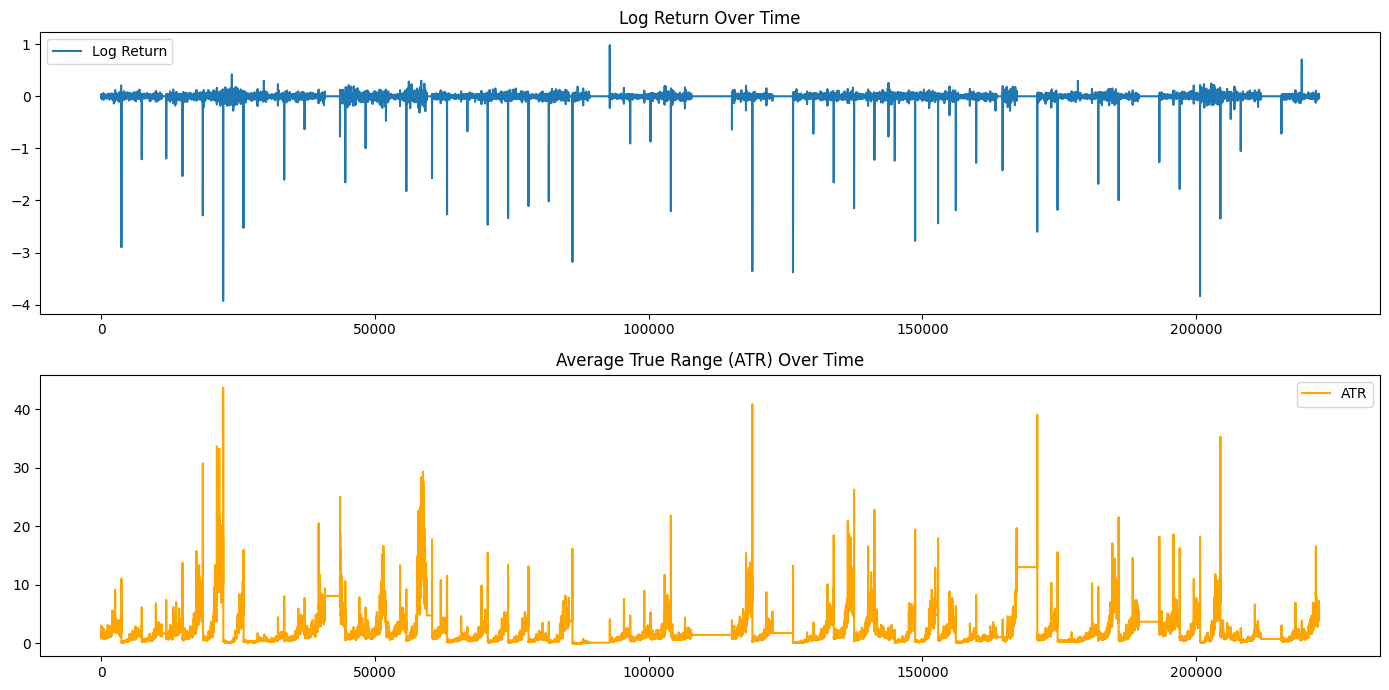

In [ ]:
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data['Log Return'], label='Log Return')
plt.title('Log Return Over Time')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(data['ATR'], label='ATR', color='orange')
plt.title('Average True Range (ATR) Over Time')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data[['Log Return', 'ATR']] = scaler.fit_transform(data[['Log Return', 'ATR']])

In [ ]:
data.head()

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Log Return,ATR
13,2010-01-22,MMM,43.200222,68.127090,69.255852,67.976585,68.896324,5751564.0,-0.406333,-0.453471
14,2010-01-25,MMM,43.385792,68.419731,69.306023,68.127090,68.837791,4050374.0,0.117355,-0.441249
15,2010-01-26,MMM,43.279747,68.252510,69.172241,67.759193,68.110367,3753048.0,-0.066795,-0.438145
16,2010-01-27,MMM,43.634987,68.812706,69.264214,67.734116,68.001671,6060012.0,0.223685,-0.443383
17,2010-01-28,MMM,42.813194,67.516724,69.096992,66.145485,69.080269,8157557.0,-0.519861,-0.406717


In [ ]:
train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)

Training data shape: (39644, 10)
Testing data shape: (9911, 10)


In [ ]:
!pip install hmmlearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
from hmmlearn import hmm

In [ ]:
#CAIC
def calculate_caic(log_likelihood, num_params, num_samples):
    return -2 * log_likelihood + num_params * (math.log(num_samples) + 1)

#HQIC
def calculate_hqic(log_likelihood, num_params, num_samples):
    return -2 * log_likelihood + 2 * num_params * math.log(math.log(num_samples))


In [ ]:
def evaluate_hmm(X, n_components, num_samples):
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
    model.fit(X)

    log_likelihood = model.score(X)
    num_params = n_components * (n_components - 1) + 2 * n_components * X.shape[1]  # Transition + emission parameters

    # AIC
    aic = -2 * log_likelihood + 2 * num_params

    # BIC
    bic = -2 * log_likelihood + num_params * np.log(num_samples)

    # CAIC
    caic = calculate_caic(log_likelihood, num_params, num_samples)

    # HQIC
    hqic = calculate_hqic(log_likelihood, num_params, num_samples)

    return aic, bic, caic, hqic, log_likelihood


In [ ]:
import numpy as np
import pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.cluster import KMeans

# Your data (assuming Log Return and ATR values are stored in X)
X = data[['Log Return', 'ATR']].values
num_samples = len(X)

# Range of states to evaluate (2 to 6)
n_states_range = range(2, 7)

# Function to evaluate HMM with given number of states
def evaluate_hmm(X, n_components, num_samples):
    # Initialize HMM with K-means for better performance
    kmeans = KMeans(n_clusters=n_components).fit(X)
    model = GaussianHMM(n_components=n_components, n_iter=100, init_params='cm')

    # Initialize model with K-means clustering labels
    model.means_ = kmeans.cluster_centers_

    # Fit the HMM model
    model.fit(X)

    # Calculate log likelihood and other model selection criteria
    log_likelihood = model.score(X)
    num_parameters = n_components ** 2 + 2 * n_components * X.shape[1]  # Approximation of number of parameters
    aic = -2 * log_likelihood + 2 * num_parameters
    bic = -2 * log_likelihood + num_parameters * np.log(num_samples)
    caic = -2 * log_likelihood + num_parameters * (np.log(num_samples) + 1)
    hqic = -2 * log_likelihood + 2 * num_parameters * np.log(np.log(num_samples))

    return aic, bic, caic, hqic, log_likelihood

# Store the results for each number of states
results = []

# Evaluate HMM for each number of states
for n_components in n_states_range:
    print(f"Evaluating HMM with {n_components} states...")
    aic, bic, caic, hqic, log_likelihood = evaluate_hmm(X, n_components, num_samples)

    # Append results
    results.append({
        'States': n_components,
        'AIC': aic,
        'BIC': bic,
        'CAIC': caic,
        'HQIC': hqic,
        'Log Likelihood': log_likelihood
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


Evaluating HMM with 2 states...


Evaluating HMM with 3 states...


Evaluating HMM with 4 states...


Evaluating HMM with 5 states...


Evaluating HMM with 6 states...
   States            AIC            BIC           CAIC           HQIC  \
0       2  132925.425236  133031.155297  133043.155297  132958.558416   
1       3  102526.512314  102711.539921  102732.539921  102584.495380   
2       4   57029.444099   57311.390929   57343.390929   57117.799247   
3       5   43982.780630   44379.268360   44424.268360   44107.030057   
4       6   41445.634163   41974.284469   42034.284469   41611.300066   

   Log Likelihood  
0   -66450.712618  
1   -51242.256157  
2   -28482.722049  
3   -21946.390315  
4   -20662.817081  


Regime Analysis:
   Regime Log Return                 ATR                 Close            
               mean       std      mean       std        mean         std
0      0   0.015528  0.388170 -0.379368  0.092438   75.520440   30.574426
1      1  -1.684527  9.416197  1.586261  2.912619  119.556329  140.272555
2      2   0.013968  0.475036  0.020842  0.178769  119.093275   41.455324
3      3   0.012924  0.491646  1.650761  1.093307  274.035404  114.640984
4      4   0.015730  0.478442 -0.656495  0.071091   26.123045   15.636714


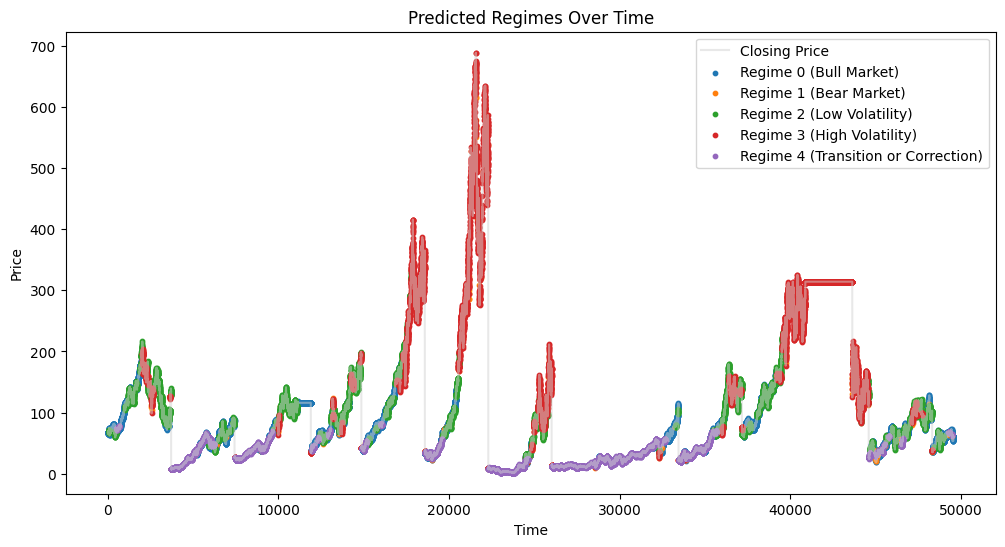

      Regime              Regime Label
13         0               Bull Market
85         2            Low Volatility
536        4  Transition or Correction
2036       1               Bear Market
2037       3           High Volatility
The predicted regime for the next observation is: 0 (Bull Market)


In [ ]:
import numpy as np
import pandas as pd
from hmmlearn import hmm
import matplotlib.pyplot as plt


# Assuming your dataset has 'Log Return' and 'ATR' columns
X = data[['Log Return', 'ATR']].values

# Define the number of states
n_states = 5

# Fit the HMM model
model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000)
model.fit(X)

# Predict hidden states (regimes)
hidden_states = model.predict(X)

# Add predicted states to the dataframe for analysis
data['Regime'] = hidden_states

# Calculate mean and standard deviation of Log Return and ATR for each regime
regime_analysis = data.groupby('Regime').agg({
    'Log Return': ['mean', 'std'],
    'ATR': ['mean', 'std'],
    'Close': ['mean', 'std']
}).reset_index()

print("Regime Analysis:\n", regime_analysis)

# Define labels based on the analysis
regime_labels = {
    0: "Bull Market",
    1: "Bear Market",
    2: "Low Volatility",
    3: "High Volatility",
    4: "Transition or Correction"
}

# Map labels to the regimes in the dataframe
data['Regime Label'] = data['Regime'].map(regime_labels)

# Visualizing the regimes over time
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Closing Price', color='lightgray', alpha=0.5)
for i in range(n_states):
    plt.scatter(data.index[data['Regime'] == i], data['Close'][data['Regime'] == i], label=f'Regime {i} ({regime_labels[i]})', s=10)

plt.title('Predicted Regimes Over Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Print the updated DataFrame with regime labels
print(data[['Regime', 'Regime Label']].drop_duplicates())

# Predict the next regime using the last observation
last_observation = X[-1].reshape(1, -1)  # Last observed Log Return and ATR
next_regime = model.predict(last_observation)

# Output the predicted regime for the next observation
print(f"The predicted regime for the next observation is: {next_regime[0]} ({regime_labels[next_regime[0]]})")
